In [ ]:
!pip install fastai -Uqqq

     |████████████████████████████████| 194kB 5.6MB/s 
     |██████████████████████          | 534.3MB 1.5MB/s eta 0:02:47

In [ ]:
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from fastai.vision.all import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Path("./drive/MyDrive/data/mall").ls()

(#2) [Path('drive/MyDrive/data/mall/mall_gt.mat'),Path('drive/MyDrive/data/mall/frames')]

In [ ]:
!cp -r drive/MyDrive/data/mall /mall/

In [ ]:
labels = loadmat('mall/mall_gt.mat')['frame'][0]

In [ ]:
label = labels[0] # extract GT for first frame
ground_truth = (label[0][0][0]) # GT array
ground_truth.shape

(29, 2)

In [ ]:
ground_truth[:3]

array([[126.77986348,  60.70477816],
       [116.95051195,  47.59897611],
       [175.10750853,  44.3225256 ]])

In [ ]:
# add source
def generate_label(label_info, image_shape=(480,640)):
    "Generate a density map based on objects positions"
    # create an empty density map
    label = np.zeros(image_shape, dtype=np.float32)

    # loop over objects positions and marked them with 100 on a label
    for x, y, *_ in label_info:
        if y < image_shape[0] and x < image_shape[1]:
            label[int(y)][int(x)] = 100

#     apply a convolution with a Gaussian kernel
#     label = gaussian_filter(label, sigma=(1, 1), order=0)

    return label

In [ ]:
l = generate_label(ground_truth)
l.shape

(480, 640)

In [ ]:
# l = l.astype('int8')
l.sum()

2900.0

In [ ]:
# Density Map Tensor
class TensorDMap(TensorImageBase): 
    _show_args = {'alpha':0.5, 'cmap':'hot'}
    def show(self, ctx=None, **kwargs):
        return show_image(self, ctx=ctx, title=str(array(self).sum()),**{**self._show_args, **kwargs})
TensorDMap._tensor_cls = TensorDMap

In [ ]:
# # Density Map type
# class DMap(PILBase): 
#     _open_args,_show_args = {'mode':'L'},{'alpha':0.5, 'cmap':'hot'}
    
#     def show(self, ctx=None, **kwargs):
#         x = array(self).astype('float') # onvert to float for next step
#         x =  gaussian_filter(x, sigma=(1, 1), order=0) # create density map
#         ax = plt.imshow(x, **self._show_args);
#         return ax

# # DMap._tensor_cls = TensorDMap

In [ ]:
def get_lbl(fn):
    indx = int(re.findall('.+/seq_(\d+).jpg', str(fn))[0])-1 # extract indx from fn
    lbl = labels[indx]
    return generate_label(lbl[0][0][0], (480,640))

In [ ]:
# Density Map type
class DMap(PILBase): 
    _open_args,_show_args = {'mode':'L'},{'alpha':0.5, 'cmap':'hot'}
    @classmethod
    def create(cls, fn):
        if isinstance(fn,ndarray): 
            l = fn
        else:
            l = get_lbl(fn)
        l = gaussian_filter(l, sigma=(4, 4), order=0)
        return cls(Image.fromarray(l))
    def show(self, ctx=None, **kwargs):
        ax = plt.imshow(array(self), **self._show_args);
        return ax

# DMap._tensor_cls = TensorDMap

In [ ]:
# Density Map type
class DMap(PILBase): 
    _open_args,_show_args = {'mode':'L'},{'alpha':0.5, 'cmap':'hot'}
    @classmethod
    def create(cls, fn):
        if isinstance(fn,ndarray): 
            l = fn
        else:
            l = get_lbl(fn)
        l = gaussian_filter(l, sigma=(4, 4), order=0)
        return cls(Image.fromarray(l))
    def show(self, ctx=None, **kwargs):
        ax = show_image(array(self), title=str(array(self).sum()), ctx=ctx, **self._show_args);
        return ax

DMap._tensor_cls = TensorDMap

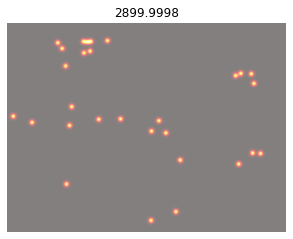

In [ ]:
dm = DMap.create(l)
dm.show();

In [ ]:
fn = 'mall/frames/seq_000001.jpg'

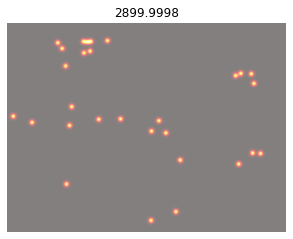

In [ ]:
dm = DMap.create(fn)
dm.show();

In [ ]:
type(dm)

__main__.DMap

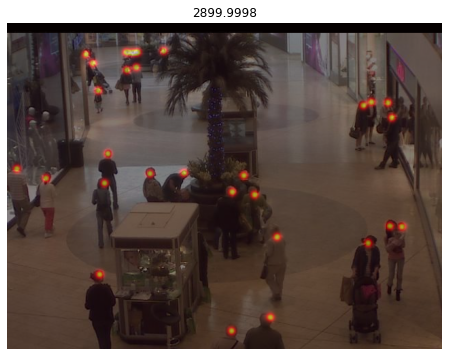

In [ ]:
img = PILImage.create(fn)
ax = show_image(img,figsize=(12,6))
dm.show(ctx=ax);

In [ ]:
tup = (img, dm)
rtup = RandomCrop(224)(tup)
x, y = rtup
x.shape, y.shape

((224, 224), (224, 224))

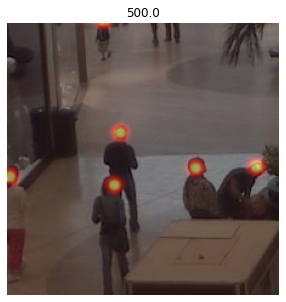

In [ ]:
ax = x.show()
y.show(ctx=ax);

In [ ]:
files = sorted(get_image_files('mall/frames/'))
len(files)

2000

In [ ]:
dset = Datasets(files, [[PILImage.create], [DMap.create]], splits=[list(range(800)), list(range(800,1000))])

In [ ]:
dset[0]

(PILImage mode=RGB size=640x480, DMap mode=F size=640x480)

In [ ]:
@ToTensor
def encodes(self, o:DMap): return o._tensor_cls(image2tensor(o))

In [ ]:
dls = dset.dataloaders(bs=6, after_item=[RandomCrop(224), ToTensor], 
                      after_batch=[IntToFloatTensor, #Normalize.from_stats(*imagenet_stats)
                      ],
                      )

In [ ]:
b = dls.one_batch()
b[0].shape, b[1].shape

(torch.Size([6, 3, 224, 224]), torch.Size([6, 1, 224, 224]))

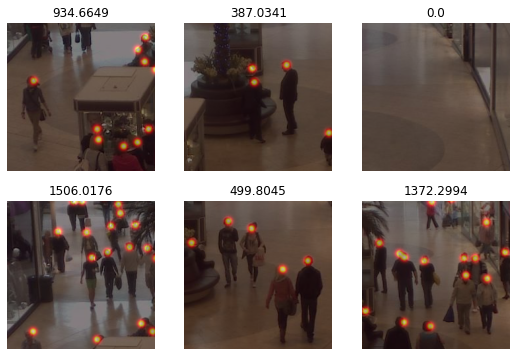

In [ ]:
dls.show_batch()

In [ ]:
i=1
img, targ = b[0][i], b[1][i]

In [ ]:
(b[0][i]).max()



TensorImage(0.7882, device='cuda:0')

In [ ]:
IntToFloatTensor()(ToTensor()(PILImage.create(fn))).max()

TensorImage(1.)

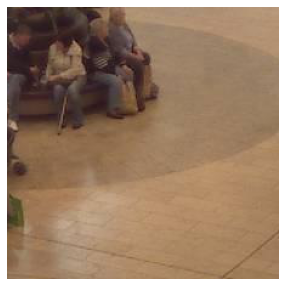

In [ ]:
show_image(img);

In [ ]:
(targ).sum()

TensorDMap(404.1049, device='cuda:0')

In [ ]:
dls = dset.dataloaders(bs=64, after_item=[RandomCrop(160), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)],
                      )

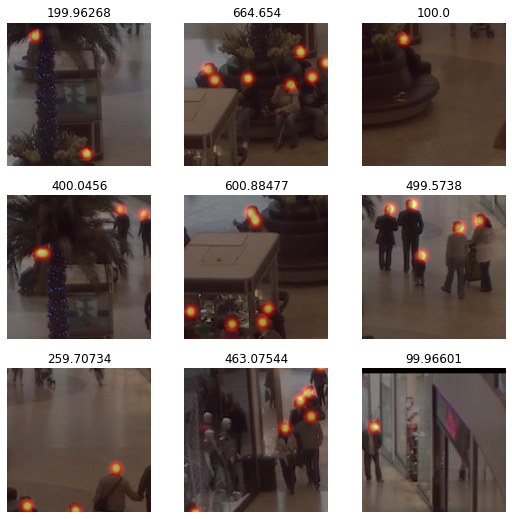

In [ ]:
dls.show_batch()

In [ ]:
m = resnet34(pretrained=True)
m = nn.Sequential(*list(m.children())[:-2])
unet = DynamicUnet(m, 1, (160, 160))

In [ ]:
learn = Learner(dls, unet, loss_func=MSELossFlat(), metrics=mae)

In [ ]:
learn.fit(15, 1e-3)

epoch,train_loss,valid_loss,mae,time
0,364.625336,0.076474,0.220978,00:17
1,160.328506,0.012469,0.051903,00:17
2,93.542328,0.013273,0.050194,00:17
3,61.106697,0.011985,0.043798,00:17
4,42.381104,0.012528,0.044669,00:17
5,30.479683,0.011600,0.039887,00:17
6,22.447672,0.011438,0.039839,00:17
7,16.805000,0.011068,0.038806,00:18
8,12.728518,0.010900,0.038440,00:17
9,9.723621,0.010724,0.043080,00:17


In [ ]:
learn.unfreeze();
learn.fit_one_cycle(30, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,mae,time
0,0.002643,0.005449,0.024402,00:17
1,0.002689,0.005466,0.024666,00:17
2,0.002626,0.005492,0.024797,00:17
3,0.002663,0.005415,0.024323,00:17
4,0.002688,0.005589,0.026793,00:17
5,0.002718,0.005463,0.025760,00:17
6,0.002718,0.005386,0.024230,00:17
7,0.002705,0.005675,0.025816,00:17
8,0.002694,0.005385,0.024171,00:17
9,0.002730,0.005455,0.024403,00:17


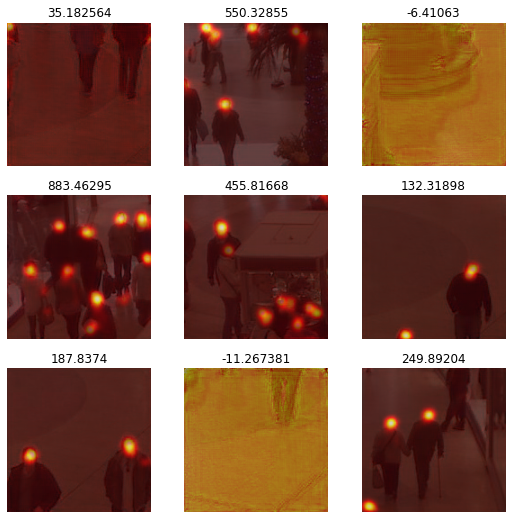

In [ ]:
learn.show_results(0)

In [ ]:
files[1000]

Path('mall/frames/seq_001001.jpg')

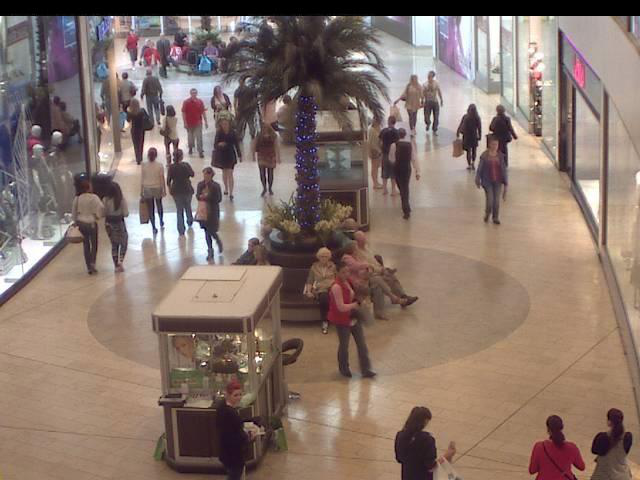

In [ ]:
PILImage.create(files[1500])

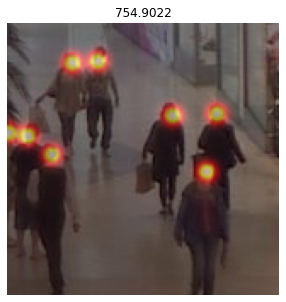

In [ ]:
img, mask = RandomCrop(160)((PILImage.create(files[1500]), DMap.create(files[1500])))
ax = img.show();
mask.show(ctx=ax);

In [ ]:
tdl = dls.test_dl([img])

In [ ]:
out, _ = learn.get_preds(dl=tdl)
out.shape

torch.Size([1, 1, 160, 160])

In [ ]:
out.sum()

TensorImage(714.9376)

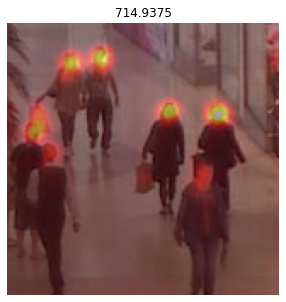

In [ ]:
ax = img.show();
TensorDMap(out.squeeze()).show(ctx=ax);

In [ ]:
out = out.squeeze()

In [ ]:
out = torch.where(out>0, out, torch.zeros_like(out))

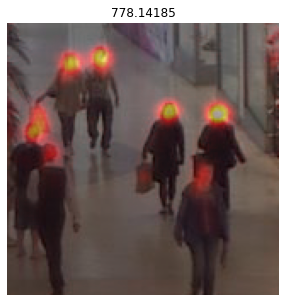

In [ ]:
ax = img.show();
TensorDMap(out.squeeze()).show(ctx=ax);

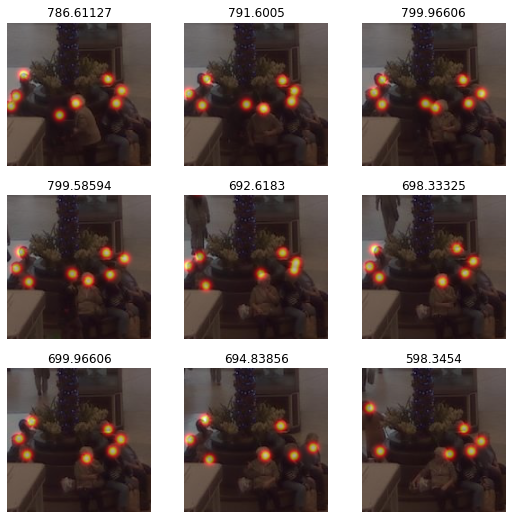

In [ ]:
dls.valid.show_batch()

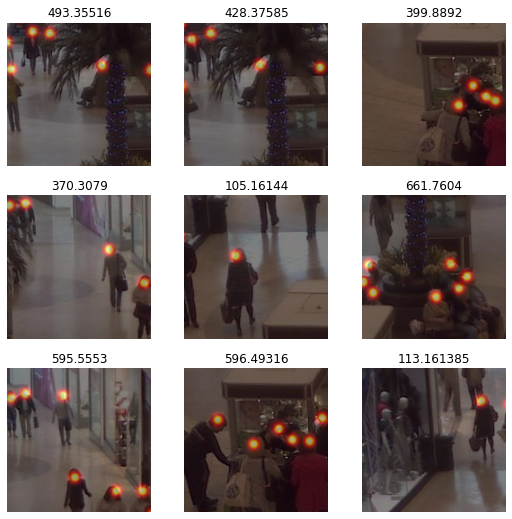

In [ ]:
with dls.valid_ds.set_split_idx(0):
  dls.valid.show_batch()

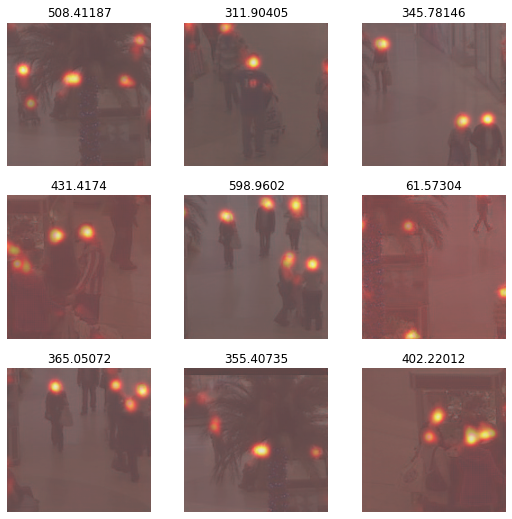

In [ ]:
with dls.valid_ds.set_split_idx(0):
  learn.show_results(alpha=.35)

In [ ]:
learn.save("crowd-res34-160px")

Path('models/crowd-res34-160px.pth')

In [ ]:
with dls.valid_ds.set_split_idx(0):
  preds = learn.get_preds()

In [ ]:
im, dn = preds[0][0], preds[0][1]

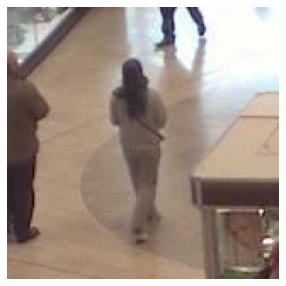

In [ ]:
RandomCrop(160)(dls.valid_ds[0][0]).show()

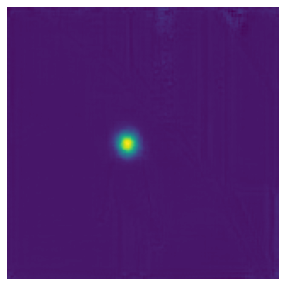

In [ ]:
show_image(im)

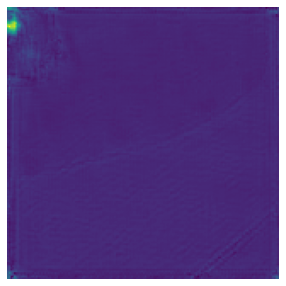

In [ ]:
show_image(dn)